<a href="https://www.kaggle.com/code/collindavies/we-re-moving-to-iowa?scriptVersionId=146518658" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# We're moving to Iowa!
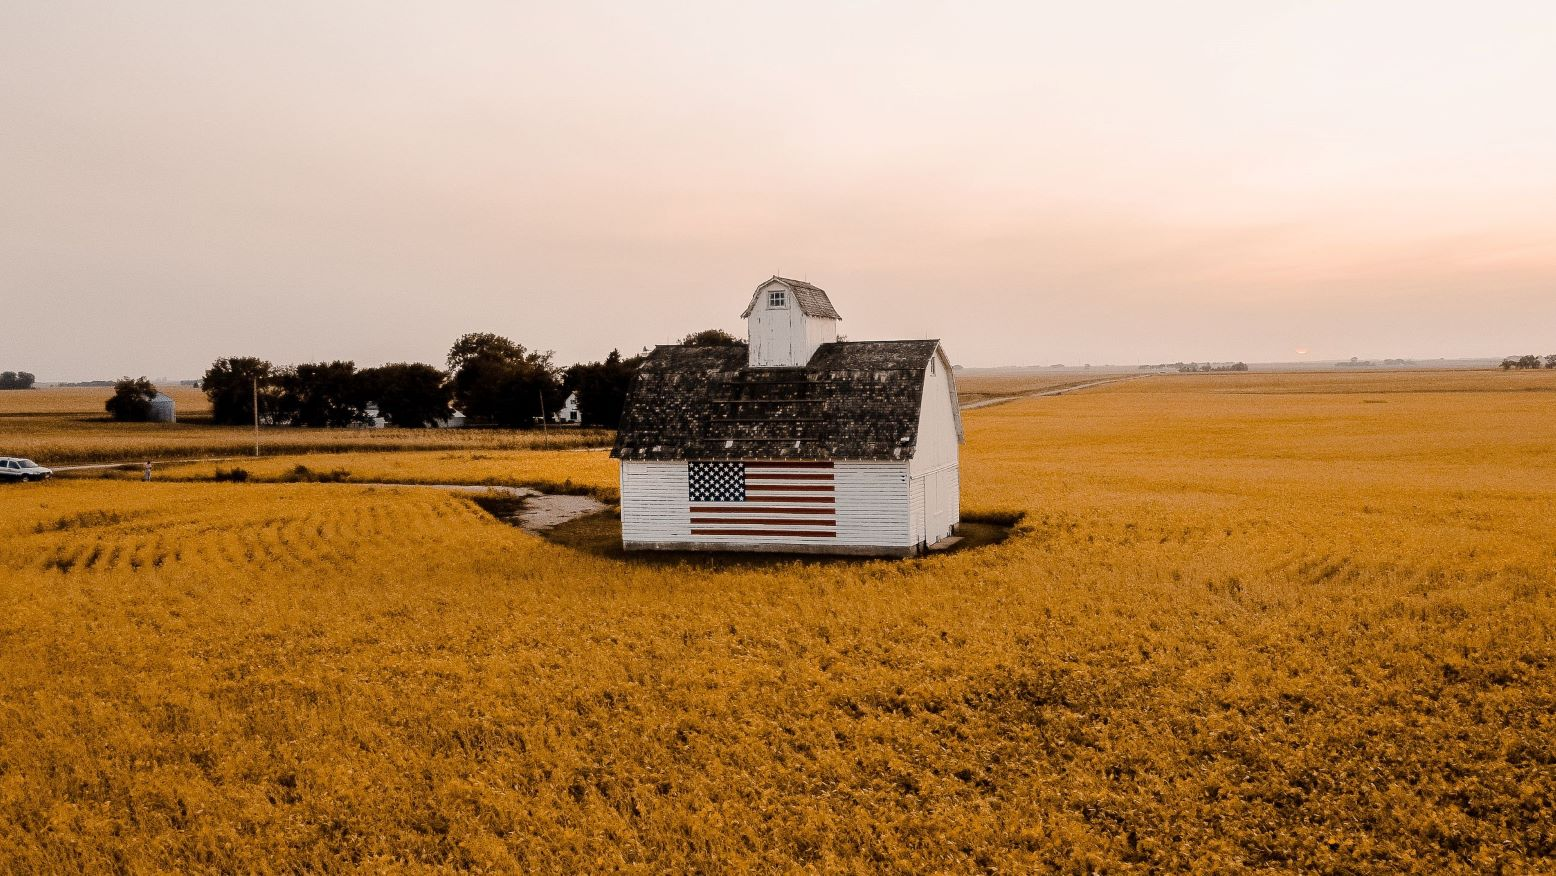
Photo by <a href="https://unsplash.com/@austingoode?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Austin Goode</a> on <a href="https://unsplash.com/photos/5pgJvOf_Lew?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>
  

## Overview
The goal of this competition is to predict the sale price of homes in Ames, IA during 2006-2010. <br>

Kaggle provides two datasets: a dataset intended for model training purposes that includes the 'SalePrice' target, and a test dataset that lacks the 'SalePrice' target. <br>

There are endless ways to approach this problem. In this kernel, I describe the approach I took to achieve a public leaderboard score of **0.11799 (top 2%)**. <br>

Here we go!

## Key Learnings
Before we go too far, I want to share the most important things I learned during this project. <br>
->First, **removing outliers** from the training set will likely improve your CV score on the training set, but, in my experience (and others'), it **does not help your ultimate leaderboard score on the test set**. Folks removing outliers from the training set and posting CV scores on the training set less than 0.1 most likely didn't score as well on the public leaderboard! <br>

->Second, **simply rounding the final SalePrice predictions improved my leaderboard score**. Nearly all SalePrice values in the training dataset have the last significant figure in the hundreds or thousands place. It didn't make sense to be predicting a SalePrice of 145,928.8492719405.... I stepped through rounding to the nearest 100, 500, 1,000, 2,500, and 5,000 and found my best score when rounding to the nearest 2,500. <br> 
***What do you think about this? Do you know of anyone else who tried this and had some success?***




## Workflow
1. Research project
2. Explore datasets
3. Process datasets
4. Engineer new features
5. Transform features
6. Create benchmark model
7. Build models + hyperparameter tuning
8. Build ensemble
9. Round final predictions
10. Submit final predictions

# 1. Research
Many others have already invested countless hours to develop performant and accurate solutions to the Ames, IA housing challenge. <br> 
Take the time to learn from the many wins and loses archived in the **Code** and **Discussion** sections of this competition to ***efficiently*** learn machine learning, explore these datasets, and build a solution that you're proud of! <br>

### As I've heard many times (and found to be true), "An hour spent in the library is worth a month in the laboratory."


Here are a few kernels that I found most useful: <br>
-[Top 3% housing: 8 Insights, 4 Learnings and 2 Questions (after 50+ hours)](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/discussion/170472) by [Jesse van Elteren](https://www.kaggle.com/jvanelteren) <br>
-[Feature Engineering for House Prices](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices) by Kaggle staff [Ryan Holbrook](https://www.kaggle.com/ryanholbrook), [Alexis Cook](https://www.kaggle.com/alexisbcook), and [Vincent Roseberry](https://www.kaggle.com/rosebv)  <br>
-[Top 3% - EDA & Feature Engineering & OOF](https://www.kaggle.com/code/mustafacicek/top-3-eda-feature-engineering-oof/notebook) by [Mustafa Cicek](https://www.kaggle.com/mustafacicek)

# 2. Explore datasets
At this point, I jumped into the data and confirmed for myself many of the things that I'd already learned about: <br>
-SalePrice and many other numerical features are skewed and could benefit from some sort of normalization <br>
-Some features contain many NA values by design (the home doesn't have a pool, fence, alley access, basement, 2nd story, etc.) while others seem to be missing key values that need to be imputed (SaleType, KitchenQual, Utilities, etc.) <br>
-Some entries may be outliers (large homes sold for relatively low prices) <br>
-Many fields would be easier to work with once converted to numerics (Qual and Cond features, for instance) <br>
-And something I realized late in my work: most SalePrice values in the training dataset end in 500 or 000. In other words, rounding final predictions to the nearest 100, 500, or 1000 may be useful <br>
***^^(I haven't seen anyone else doing this, although I bet someone has. What do you think about the value of rounding final predictions?)***

# 3. Process datasets

In [ ]:
import warnings
from datetime import datetime

import lightgbm as lgb
import numpy as np
import pandas as pd
import xgboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from pandas.api.types import CategoricalDtype
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, skew, yeojohnson
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (ElasticNet, ElasticNetCV, Lasso, LassoCV,
                                  Ridge, RidgeCV)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

In [ ]:
# Load datasets
root_dir = '/kaggle/input/house-prices-advanced-regression-techniques'

train_df = pd.read_csv(f'{root_dir}/train.csv')
test_df = pd.read_csv(f"{root_dir}/test.csv")
print('Data loaded!')

In [ ]:
# Fill missing values that might lead to data leakage
def fill_na_leak(Frame):
    mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
                 'Exterior2nd', 'SaleType', 'Utilities'
                ]
    for i in mode_cols:
        Frame[i] = Frame[i].fillna(Frame[i].mode()[0])

    Frame["LotFrontage"] = Frame.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    return Frame

train_df = fill_na_leak(train_df)
test_df = fill_na_leak(test_df)

In [ ]:
# Combine train and test dfs
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(train_df, test_df)

In [ ]:
# Fill missing values
none_cols = ['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'Alley',
             'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
             'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass',
            ]
for i in none_cols:
    df_all[i] = df_all[i].fillna("None")

zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
             'GarageArea', 'GarageCars'
            ]
for i in zero_cols:
    df_all[i] = df_all[i].fillna(0)

df_all["Functional"] = df_all["Functional"].fillna("Typ")

# 4. Engineer new features

In [ ]:
# New features
df_all["MedNhbdArea"] = df_all.groupby("Neighborhood")["GrLivArea"].transform("median")
df_all['Total_sqr_footage'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['BsmtFinSF1'] + df_all['BsmtFinSF2']

df_all["LivLotRatio"] = df_all.GrLivArea / df_all.LotArea
df_all["Outlier"] = (df_all.Neighborhood == "Edwards") & (df_all.SaleCondition == "Partial")

df_all['YrBltAndRemod'] = df_all['YearBuilt'] + df_all['YearRemodAdd']
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

df_all['Total_sqr_footage'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] +
                                 df_all['1stFlrSF'] + df_all['2ndFlrSF'])

df_all['Total_Bathrooms'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))

df_all['Total_porch_sf'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                              df_all['EnclosedPorch'] + df_all['ScreenPorch'] +
                              df_all['WoodDeckSF'])

df_all['haspool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['has2ndfloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasgarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasbsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasfireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df_all["Older1945"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["30", "70"] else 0)
df_all["Newer1946"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["20", "60", "120", "160"] else 0)
df_all["AllStyles"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["20", "90", "190"] else 0)
df_all["AllAges"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["40", "45", "50", "75", "90", "150", "190"] else 0)
df_all["Pud"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["120", "150", "160", "180"] else 0)
df_all["Split"] = df_all["MSSubClass"].apply(lambda x: 1 if x in ["80", "85""180"] else 0)
df_all["MSSubClass"] = df_all["MSSubClass"].apply(lambda x: "180" if x == "150" else x)
df_all["MSZoning"] = df_all["MSZoning"].apply(lambda x: "R" if x.startswith("R") else x)
df_all["North"] = df_all["Neighborhood"].apply(lambda x: 1 if x in ["Blmngtn", "BrDale", "ClearCr", "Gilbert",  "Names", "NoRidge", 
                                                              "NPkVill", "NWAmes", "NoRidge", "NridgHt", "Sawyer", "Somerst", 
                                                              "StoneBr", "Veenker", "NridgHt"] else 0)
df_all["South"] = df_all["Neighborhood"].apply(lambda x: 1 if x in ["Blueste", "Edwards", "Mitchel", "MeadowV", 
                                                              "SWISU", "IDOTRR", "Timber"] else 0)
df_all["Downtown"] = df_all["Neighborhood"].apply(lambda x: 1 if x in ["BrkSide", "Crawfor", "OldTown", "CollgCr"] else 0)
df_all["East"] = df_all["Neighborhood"].apply(lambda x: 1 if x in ["IDOTRR", "Mitchel"] else 0)
df_all["West"] = df_all["Neighborhood"].apply(lambda x: 1 if x in ["Edwards", "NWAmes", "SWISU", "Sawyer", "SawyerW"] else 0)
df_all.loc[(df_all["Condition1"] == "Feedr") | (df_all["Condition2"] == "Feedr"), "StreetDegree"] = 1
df_all.loc[(df_all["Condition1"] == "Artery") | (df_all["Condition2"] == "Artery"), "StreetDegree"] = 2
df_all["StreetDegree"].fillna(0, inplace = True)
df_all.loc[(df_all["Condition1"].isin(["RRNn", "RRNe"])) | (df_all["Condition2"].isin(["RRNn", "RRNe"])), "RailroadDegree"] = 1
df_all.loc[(df_all["Condition1"].isin(["RRAn", "RRAe"])) | (df_all["Condition2"].isin(["RRAn", "RRAe"])), "RailroadDegree"] = 2
df_all["RailroadDegree"].fillna(0, inplace = True)
df_all.loc[(df_all["Condition1"] == "PosN") | (df_all["Condition2"] == "PosN"), "OffsiteFeature"] = 1
df_all.loc[(df_all["Condition1"] == "PosA") | (df_all["Condition2"] == "PosA"), "OffsiteFeature"] = 2
df_all["OffsiteFeature"].fillna(0, inplace = True)
df_all["Norm1"] = df_all["Condition1"].apply(lambda x: 1 if x == "Norm" else 0)
df_all["Norm2"] = df_all["Condition2"].apply(lambda x: 1 if x == "Norm" else 0)
df_all["Norm"] = df_all["Norm1"] + df_all["Norm2"]
df_all.drop(["Norm1", "Norm2"], axis = 1, inplace = True)
df_all["BldgType"] = df_all["BldgType"].apply(lambda x: "2Fam" if x in ["2fmCon", "Duplex"] else x)
df_all["SaleType"] = df_all["SaleType"].apply(lambda x: "WD" if x.endswith("WD") else x)
df_all["SaleType"] = df_all["SaleType"].apply(lambda x: "Contract" if x.startswith("Con") else x)
df_all["SaleType"] = df_all["SaleType"].apply(lambda x: "Oth" if x == "COD" else x)
df_all["SaleCondition"] = df_all["SaleCondition"].apply(lambda x: "Abnormal_Adjland" if x in ["Abnorml", "AdjLand"] else x)
df_all["SaleCondition"] = df_all["SaleCondition"].apply(lambda x: "Alloca_Family" if x in ["Alloca", "Family"] else x)
df_all["SaleCondition"] = df_all["SaleCondition"].apply(lambda x: "Other" if x in ["Abnormal_Adjland", "Alloca_Family"] else x)
df_all["GarageType"] = df_all["GarageType"].apply(lambda x: "Carport_None" if x in ["CarPort", "None"] else x)
df_all["GarageType"] = df_all["GarageType"].apply(lambda x: "Basement_2Types" if x in ["Basment", "2Types"] else x)
df_all["LotConfig"] = df_all["LotConfig"].apply(lambda x: "CulDSac_FR3" if x in ["CulDSac", "FR3"] else x)
df_all["RoofStyle"] = df_all["RoofStyle"].apply(lambda x: "Other" if x not in ["Gable"] else x)
df_all["RoofMatl"] = df_all["RoofMatl"].apply(lambda x: "Other" if x != "CompShg" else x)
df_all["MasVnrType"] = df_all["MasVnrType"].apply(lambda x: "None_BrkCmn" if x in ["None", "BrkCmn"] else x)
df_all["Foundation"] = df_all["Foundation"].apply(lambda x: "BrkTil_Stone" if x in ["BrkTil", "Stone"] else x)
df_all["Foundation"] = df_all["Foundation"].apply(lambda x: "BrkTil_Stone_Slab" if x in ["BrkTil_Stone", "Slab"] else x)
df_all["Foundation"] = df_all["Foundation"].apply(lambda x: "PConc_Wood" if x in ["PConc", "Wood"] else x)
df_all["Heating"] = df_all["Heating"].apply(lambda x: "Other" if x != "GasA" else x)

lotshape = {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4}
landcontour = {"Low":1, "HLS": 2, "Bnk":3, "Lvl": 4}
utilities = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
landslope = {"Sev": 1, "Mod": 2, "Gtl": 3}

general = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

bsmtexposure = {"None": 0, "No": 0, "Mn": 1, "Av": 2, "Gd": 3}
bsmtfintype = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
electrical = {"Mix": 1, "FuseP": 2, "FuseF": 3, "FuseA": 4, "SBrkr": 5}
functional = {"Typ": 1, "Min1": 2, "Min2": 3, "Mod": 4, "Maj1": 5, "Maj2": 6, "Sev": 7, "Sal": 8}
garagefinish = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
fence = {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

df_all.replace({"LotShape": lotshape, "LandContour": landcontour, "Utilities": utilities, "LandSlope": landslope, 
             "BsmtExposure": bsmtexposure, "BsmtFinType1": bsmtfintype, "BsmtFinType2":bsmtfintype, "Electrical": electrical, 
             "Functional": functional, "GarageFinish": garagefinish, "Fence": fence}, 
             inplace = True)

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
            "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]:
    df_all[col] = df_all[col].replace(general)



df_all["FrontageRatio"] = (df_all["LotFrontage"] / df_all["LotArea"])
df_all["HQFloor"] = df_all["1stFlrSF"] + df_all["2ndFlrSF"]
df_all["FloorAreaRatio"] = df_all["GrLivArea"] / df_all["LotArea"]
df_all["TotalArea"] = df_all["TotalBsmtSF"] + df_all["GrLivArea"]
df_all["TotalPorch"] = df_all["WoodDeckSF"] + df_all["OpenPorchSF"] + df_all["EnclosedPorch"] + df_all["3SsnPorch"] + df_all["ScreenPorch"]
df_all["WeightedBsmtFinSF1"] = df_all["BsmtFinSF1"] * df_all["BsmtFinType1"]
df_all["WeightedBsmtFinSF2"] = df_all["BsmtFinSF2"] * df_all["BsmtFinType2"]
df_all["WeightedTotalBasement"] =  df_all["WeightedBsmtFinSF1"] + df_all["BsmtFinSF2"] * df_all["BsmtFinType2"] +  df_all["BsmtUnfSF"]
df_all["TotalFullBath"] = df_all["BsmtFullBath"] + df_all["FullBath"]
df_all["TotalHalfBath"] = df_all["BsmtHalfBath"] + df_all["HalfBath"]
df_all["TotalBsmtBath"] = df_all["BsmtFullBath"] + 0.5 * df_all["BsmtHalfBath"]
df_all["TotalBath"] = df_all["TotalFullBath"] + 0.5 * (df_all["BsmtHalfBath"] + df_all["HalfBath"]) + df_all["BsmtFullBath"] + 0.5 * df_all["BsmtHalfBath"]
df_all["HasPool"] = df_all["PoolArea"].apply(lambda x: 0 if x == 0 else 1)
df_all["Has2ndFlr"] = df_all["2ndFlrSF"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasBsmt"] = df_all["TotalBsmtSF"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasFireplace"] = df_all["Fireplaces"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasGarage"] = df_all["GarageArea"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasLowQual"] = df_all["LowQualFinSF"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasPorch"] = df_all["TotalPorch"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasMiscVal"] = df_all["MiscVal"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasWoodDeck"] = df_all["WoodDeckSF"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasOpenPorch"] = df_all["OpenPorchSF"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasEnclosedPorch"] = df_all["EnclosedPorch"].apply(lambda x: 0 if x == 0 else 1)
df_all["Has3SsnPorch"] = df_all["3SsnPorch"].apply(lambda x: 0 if x == 0 else 1)
df_all["HasScreenPorch"] = df_all["ScreenPorch"].apply(lambda x: 0 if x == 0 else 1)
df_all["TotalPorchType"] = df_all["HasWoodDeck"] + df_all["HasOpenPorch"] + df_all["HasEnclosedPorch"] + df_all["Has3SsnPorch"] + df_all["HasScreenPorch"]
df_all["TotalPorchType"] = df_all["TotalPorchType"].apply(lambda x: 3 if x >=3 else x)
df_all["RestorationAge"] = df_all["YearRemodAdd"] - df_all["YearBuilt"]
df_all["RestorationAge"] = df_all["RestorationAge"].apply(lambda x: 0 if x < 0 else x)
df_all["HasRestoration"] = df_all["RestorationAge"].apply(lambda x: 0 if x == 0 else 1)
df_all["YearAfterRestoration"] = df_all["YrSold"] - df_all["YearRemodAdd"]
df_all["YearAfterRestoration"] = df_all["YearAfterRestoration"].apply(lambda x: 0 if x < 0 else x)
df_all["BuildAge"] = df_all["YrSold"] - df_all["YearBuilt"]
df_all["BuildAge"] = df_all["BuildAge"].apply(lambda x: 0 if x < 0 else x)
df_all["IsNewHouse"] = df_all["BuildAge"].apply(lambda x: 1 if x == 0 else 0)

def year_map(year):
    # 1: GildedAge, 2: ProgressiveEra, 3: WorldWar1, 4: RoaringTwenties, 5: GreatDepression, 
    # 6: WorlWar2, 7: Post-warEra, 8: CivilRightsEra, 9: ReaganEra, 10: Post-ColdWarEra, 11: ModernEra
    year = 1 if year <= 1895 else\
    (2 if year <= 1916 else\
     (3 if year <= 1919 else\
      (4 if year <= 1929 else\
       (5 if year <= 1941 else\
        (6 if year <= 1945 else\
         (7 if year <= 1964 else\
          (8 if year <= 1980 else\
           (9 if year <= 1991 else\
            (10 if year < 2008 else 11))))))))) 
    
    return year

df_all["YearBuilt_bins"] = df_all["YearBuilt"].apply(lambda year: year_map(year))
df_all["YearRemodAdd_bins"] = df_all["YearRemodAdd"].apply(lambda year: year_map(year))
df_all["GarageYrBlt_bins"] = df_all["GarageYrBlt"].apply(lambda year: year_map(year))
df_all["YrSold"] = df_all["YrSold"].astype(str)
df_all["MoSold"] = df_all["MoSold"].astype(str)
df_all["Season"] = df_all["MoSold"].apply(lambda x: "Winter" if x in ["12", "1", "2"] else\
                                   ("Spring" if x in ["3", "4", "5"] else\
                                   ("Summer" if x in ["6", "7", "8"] else "Fall")))
df_all["OverallValue"] = df_all["OverallQual"] * df_all["OverallCond"]
df_all["ExterValue"] = df_all["ExterQual"] * df_all["ExterCond"]
df_all["BsmtValue"] = ((df_all["BsmtQual"] + df_all["BsmtFinType1"] + df_all["BsmtFinType2"]) * df_all["BsmtCond"]) / 2
df_all["KitchenValue"] = df_all["KitchenAbvGr"] * df_all["KitchenQual"]
df_all["FireplaceValue"] = df_all["Fireplaces"] * df_all["FireplaceQu"]
df_all["GarageValue"] = df_all["GarageQual"] * df_all["GarageCond"]
df_all["TotalValue"] = df_all["OverallValue"] + df_all["ExterValue"] + df_all["BsmtValue"] + df_all["KitchenValue"] + df_all["FireplaceValue"] + df_all["GarageValue"] +\
df_all["HeatingQC"] + df_all["Utilities"] + df_all["Electrical"] - df_all["Functional"]  + df_all["PoolQC"]

df_all["TotalQual"] = df_all["OverallQual"] + df_all["ExterQual"] + df_all["BsmtQual"] + df_all["KitchenQual"] + df_all["FireplaceQu"] + df_all["GarageQual"] +\
df_all["HeatingQC"] + df_all["PoolQC"]

df_all["TotalCond"] = df_all["OverallCond"] + df_all["ExterCond"] + df_all["BsmtCond"] + df_all["GarageCond"]
df_all["TotalQualCond"] = df_all["TotalQual"] + df_all["TotalCond"]
df_all["BsmtSFxValue"] = df_all["TotalBsmtSF"] * df_all["BsmtValue"]
df_all["BsmtSFxQual"] = df_all["TotalBsmtSF"] * df_all["BsmtQual"]
df_all["TotalAreaXOverallValue"] = df_all["TotalArea"] * df_all["OverallValue"]
df_all["TotalAreaXOverallQual"] = df_all["TotalArea"] * df_all["OverallQual"]
df_all["GarageAreaXGarageValue"] = df_all["GarageArea"] * df_all["GarageValue"]
df_all["GarageAreaXGarageQual"] = df_all["GarageArea"] * df_all["GarageQual"]
df_all["LotShape"] = df_all["LotShape"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
df_all["LandSlope"] = df_all["LandSlope"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
df_all["OverallCond"] = df_all["OverallCond"].apply(lambda x: 1 if x in [1, 2, 3] else x-1)
df_all["OverallQual"] = df_all["OverallQual"].apply(lambda x: 1 if x in [1, 2] else x-1)
df_all["ExterCond"] = df_all["ExterCond"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
df_all["BsmtQual"] = df_all["BsmtQual"].apply(lambda x: 0 if x in [0, 1, 2] else (1 if x == 3 else (2 if x == 4 else 3)))
df_all["BsmtCond"] = df_all["BsmtCond"].apply(lambda x: 0 if x in [0, 1, 2] else (1 if x == 3 else 2))
df_all["BsmtFinType1"] = df_all["BsmtFinType1"].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else (2 if x == 6 else x))
df_all["BsmtFinType2"] = df_all["BsmtFinType2"].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else (2 if x == 6 else x))
df_all["HeatingQC"] = df_all["HeatingQC"].apply(lambda x: 1 if x in [1, 2] else (2 if x in [3, 4] else 3))
df_all["Electrical"] = df_all["Electrical"].apply(lambda x: 1 if x in [1, 2] else x-3)
df_all["BsmtFullBath"] = df_all["BsmtFullBath"].apply(lambda x: 2 if x >= 2 else x)
df_all["FullBath"] = df_all["FullBath"].apply(lambda x: 1 if x <= 1 else (3 if x >= 3 else x))
df_all["HalfBath"] = df_all["HalfBath"].apply(lambda x: 1 if x >= 1 else 0)
df_all["BedroomAbvGr"] = df_all["BedroomAbvGr"].apply(lambda x: 1 if x <=1 else (5 if x >= 5 else x))
df_all["KitchenAbvGr"] = df_all["KitchenAbvGr"].apply(lambda x: 1 if x <= 1 else (2 if x >= 2 else x))
df_all["TotRmsAbvGrd"] = df_all["TotRmsAbvGrd"].apply(lambda x: 3 if x <= 4 else (10 if x >= 11 else x-1))
df_all["Functional"] = df_all["Functional"].apply(lambda x: 1 if x == 1 else 2)
df_all["Fireplaces"] = df_all["Fireplaces"].apply(lambda x: 2 if x >= 2 else x)
df_all["GarageCars"] = df_all["GarageCars"].apply(lambda x: 3 if x >= 3 else x)
df_all["GarageQual"] = df_all["GarageQual"].apply(lambda x: 1 if x <= 2 else (2 if x == 3 else 3))
df_all["GarageCond"] = df_all["GarageCond"].apply(lambda x: 1 if x <= 2 else 2)
df_all["Fence"] = df_all["Fence"].apply(lambda x: 1 if x in [1, 3] else x)

In [ ]:
# Split back to train and test for this to prevent leakage
target_encoding = ["MSSubClass", "Neighborhood", "Exterior1st", "Exterior2nd", "Condition1", "Condition2", "HouseStyle"]

for col in target_encoding:
    feature_name = col + "Rank"
    df_all.loc[:, feature_name] = df_all[col].map(df_all.groupby(col).SalePrice.median())
    df_all.loc[df_all['MSSubClass'] == 150, 'MSSubClassRank'] = df_all.SalePrice.median()
    df_all.loc[:, feature_name] = df_all.loc[:, feature_name].rank(method = "dense")

df_all["Exterior"] = np.where((df_all["Exterior1st"] != df_all["Exterior2nd"]), "Mixed", df_all["Exterior1st"])
df_all["No2ndExt"] = df_all["Exterior"].apply(lambda x: 0 if x == "Mixed" else 1)

In [ ]:
# Log transform SalePrice
df_all['SalePrice'] = np.log1p(df_all['SalePrice'])

In [ ]:
# Split data back into training and test sets
train = df_all[~df_all['SalePrice'].isna()]
test = df_all[df_all['SalePrice'].isna()].drop(['SalePrice'], axis=1)

y_train = train.SalePrice.values

# 5. Transform features

In [ ]:
def col_types(df):
    num_cols = df.loc[:, df.dtypes != "object"].columns.tolist()
    cat_cols = df.loc[:, df.dtypes == "object"].columns.tolist()
    ord_cols = []
    for col in num_cols:
        if df[col].value_counts().size < 20:
            ord_cols.append(col)

    num_cols = [x for x in num_cols if x not in ord_cols + ["Id", "SalePrice"]]
    
    return num_cols, cat_cols, ord_cols

num_, cat_, ord_ = col_types(df_all)

In [ ]:
train_skew = []
test_skew = []
check_cols = [x for x in num_ if not x.endswith("Rank")]

for col in check_cols:
    train_skew.append(train[col].skew())
    test_skew.append(test[col].skew())
    
skew_df = pd.DataFrame({"Feature": check_cols, "TrainSkewness": train_skew, "TestSkewness": test_skew})
skewed = skew_df[skew_df.TrainSkewness.abs() >= 0.5]

In [ ]:
train_skew_yeoj = []
test_skew_yeoj = []

for col in skewed.Feature.tolist():
    train[col], fitted_lambda = yeojohnson(train[col])
    test[col] = yeojohnson(test[col], fitted_lambda)
    
    train_skew_yeoj.append(train[col].skew())
    test_skew_yeoj.append(test[col].skew())    
    
skewed["TrainSkewness_AfterYeoJohnson"] = train_skew_yeoj
skewed["TestSkewness_AfterYeoJohnson"] = test_skew_yeoj

In [ ]:
high_skew = skewed[skewed.TrainSkewness_AfterYeoJohnson.abs() > 1].Feature.tolist()

train.drop(high_skew, axis = 1, inplace = True)
test.drop(high_skew, axis = 1, inplace = True)

In [ ]:
df_all = concat_df(train, test)

In [ ]:
def prep_data(df, cat_cols, target):
    
    dummies = pd.get_dummies(df[cat_cols], drop_first = True)
    data = pd.concat([df, dummies], axis = 1).drop(cat_cols, axis = 1)
    
    train = data[data[target].notnull()]
    test = data[data[target].isnull()]
    
    return train, test

train, test = prep_data(df_all, cat_, "SalePrice")

In [ ]:
df_all = concat_df(train, test)

In [ ]:
# Split data back into training and test sets
train = df_all[~df_all['SalePrice'].isna()]
test = df_all[df_all['SalePrice'].isna()].drop(['SalePrice'], axis=1)

target = "SalePrice"
predictors = [x for x in train.columns if x not in ["Id", "SalePrice"]]

In [ ]:
scaler = RobustScaler()

train[predictors] = scaler.fit_transform(train[predictors])
test[predictors] = scaler.transform(test[predictors])

X_train = train[predictors]
y_train = train[target]
X_test = test[predictors]

selector = VarianceThreshold(0.01)

selector.fit(X_train)
X_train = X_train[X_train.columns[selector.get_support()]]

selector.transform(X_test)
X_test = X_test[X_test.columns[selector.get_support()]]

# 6. Create benchmark model
This is where the fun began for me. <br>
At this point, I've pulled snippets from a bunch of older kernels and put together something that sort of works. Now, I'd like to explore the impact of each decision I've made so far. Like... <br> 
Should I drop outliers? <br>
What is the best approach to handling categorical fields? <br> 
Does dropping/adding features make a difference? <br>

To tackle this, I created a benchmark model and began adding and subtracting processing steps to understand the impact of each step on the model. <br>

In [ ]:
# Define modeling approach and evaluation metric for optimization 
# Validation function
n_folds = 10

def rmsle_cv(model, train, y_train):    
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def evaluate_progress():
    # Split data back into training and test sets
    train = df_all[~df_all['SalePrice'].isna()]
    test = df_all[df_all['SalePrice'].isna()].drop(['SalePrice'], axis=1)
    
    y_train = train.SalePrice.values
    train = train.drop(['SalePrice'], axis=1)
    
    model_xgb = xgboost.XGBRegressor()
    score = rmsle_cv(model_xgb, train, y_train)
    print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    return("{:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Here are my notes... I know this doesn't provide all of the detail to understand all the variations I tested, but hopefully this provides a framework for how I systematically worked my way through each part of the data processing. <br>

In [ ]:
# Starting point -> 0.1362 (0.0181)

# Optimize for handling blank values -> 
#     Approach 1 -> 0.1328 (0.0179) w/ leakage prevention approach [SELECT]
#     Approach 2 -> 0.1348 (0.0183)
#     Approach 3 -> 0.1348 (0.0171) w/o leakage prevention approach

# Handle anomalies? Y/N
#     Y -> 0.1328 (0.0183) -> equal or worse performance [DE-SELECT]

# Categorial approach
#     Approach 1 -> 0.1328 (0.0179)
#     Approach 2 -> 0.1326 (0.0169) [SELECT]
#     Approach 3 -> 0.1327 (0.0179)
#     Approach 4 -> 0.1347 (0.0197)

# Drop blatant outliers? Y/N
#     Y -> 0.1288 (0.0138) -> but does it help with test/leaderboard score? NO. [DE-SELECT]

# Current features to drop
#     Drop -> 0.1300 (0.0197)   ['Id', 'LandSlope', 'BsmtUnfSF', 'YrSold', 'LandContour', 'KitchenAbvGr', 'WoodDeckSF',
#                                'BsmtHalfBath', 'HalfBath',] # Improves test/leaderboard score

# Add new features
#     Add -> 0.1300 (0.0143)    ['MedNhbdArea', 'Total_sqr_footage']

# Transform skewed fields
#     SalePrice - log1p - > 0.1292 (0.0131)
#     Transforming skewed features doesn't improve score for training set...


# 7. Build models + hyperparameter tuning
I chose to test a number of popular models used on this challenge previously. <br>
A handful of gradient boosting and linear regression models made the cut. <br>
Select hyperparameters for each model were tuned using BayesSearchCV, and that approach can be found here [Lightgbm, Xgboost Parameter Tuning - BayesSearchCV](https://www.kaggle.com/code/mustafacicek/lightgbm-xgboost-parameter-tuning-bayessearchcv/notebook) by [Mustafa Cicek](https://www.kaggle.com/mustafacicek).

### Hyperparameter tuning

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer, Categorical

kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

# gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
#                                 random_state = 42, n_iter_no_change = 20)

# rmsle_cv(gbr, X_train, y_train).mean()

In [ ]:
# %%time
# start = datetime.now()
# print(start)
# opt = BayesSearchCV(gbr, 
#                     {
#                         "max_depth": Integer(3, 13),
#                         "max_features": Real(0.1, 1, prior = "log-uniform"),
#                         "subsample": Real(0.25, 1),
#                         "min_samples_split": Integer(20, 120),
#                         "min_samples_leaf": Integer(1, 10),
#                         "alpha": Real(0.75, 0.95),
#                         "min_impurity_decrease": Real(0, 0.5)
#                     },
#                     n_iter = 150,
#                     cv = kf,
#                     n_jobs = -1,
#                     scoring = "neg_root_mean_squared_error",
#                     random_state = 42
#                    )
# opt.fit(X_train, y_train)
# opt.best_params_
# end = datetime.now()
# print(end)
# print("Best Score is: ", opt.best_score_, "\n")
# print("Best Parameters: ", opt.best_params_, "\n")
# gbr = opt.best_estimator_
# gbr

In [ ]:
GBoost_params = {'n_estimators': 400,
                 'learning_rate': 0.05,
                 'alpha': 0.95,
                 'max_depth': 3,
                 'max_features': 0.1,
                 'min_impurity_decrease': 0.0,
                 'min_samples_leaf': 1,
                 'min_samples_split': 20,
                 'subsample': 0.8013150724345173,
                 'loss': "huber",
                 'n_iter_no_change': 20,
                 'random_state': 42}
GBoost = GradientBoostingRegressor(**GBoost_params)


xgb_params = {#'objective': "reg:squarederror",
                #'n_jobs': -1,
                'max_depth': 3,
                'gamma': 0,
                'learning_rate': 0.0025,
                'n_estimators': 5000,
                'colsample_bytree': 0.25,
                'subsample': 1,
                'reg_alpha': 0.0,
                'reg_lambda': 0.0}
model_xgb = xgboost.XGBRegressor(**xgb_params) 


cat_params = {#'iterations': 800,
              #'learning_rate': 0.05,
              'depth': 6,
              'l2_leaf_reg': 2,
              #'eval_metric':'RMSE',
              #'early_stopping_rounds': 200,
              'verbose': 0,
              'random_seed': 42,}
cat = CatBoostRegressor(**cat_params)


lasso = Lasso(alpha=0.00012947872262452633, random_state=1)


KRR_params = {'alpha': 3,
              'max_iter': 5000,}
KRR = Ridge(**KRR_params)


ENet_params = {'alpha': 0.0002479583761526921,
               'l1_ratio': 0.8,
               'max_iter': 5000,
               'random_state': 42}
ENet = ElasticNet(**ENet_params)


lgb_params = {'colsample_bytree': 0.25,
              'max_depth': 13,
              'min_child_samples': 7,
              'min_split_gain': 0.0,
              'num_leaves': 20,
              'reg_alpha': 0.0,
              'reg_lambda': 0.0,
              'subsample': 1.0,
              'subsample_freq': 1,
              'learning_rate': 0.004,
              'n_estimators': 8000,}
model_lgb = lgb.LGBMRegressor(**lgb_params)

### Here are the scores of each tuned model.

In [ ]:
# score = rmsle_cv(GBoost, X_train, y_train)
# print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # 0.1180

# score = rmsle_cv(model_xgb, X_train, y_train)
# print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # 0.1151

# score = rmsle_cv(cat, X_train, y_train)
# print("Cat boost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # 0.1124

# score = rmsle_cv(lasso, X_train, y_train)
# print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # 0.1219

# score = rmsle_cv(KRR, X_train, y_train)
# print("K-Ridge score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std())) # 0.1223

# score = rmsle_cv(ENet, X_train, y_train)
# print("ElasticNet score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std())) # 0.1216

# score = rmsle_cv(model_lgb, X_train, y_train)
# print("LGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # 0.1148

# 8. Build ensemble
At this point, I began to build a stacking ensemble to improve my score on the leaderboard. <br>
With simply averaging the results of LGBMRegressor and CatBoost, I broke below a leaderboard score of **0.12** for the first time. <br>
From there, I manually and systematically optimized the models and ratio of each model's predictions in my final stacked model. Finally, I blended in the results of the stacked model (stack_preds). <br>

At this point, the stacked models yielded a leaderboard score of **0.11829**. <br>

In [ ]:
%%time
models = {
    "LGBMRegressor": model_lgb,
    "XGBRegressor": model_xgb,
    "GradientBoostingRegressor": GBoost,
    "CatBoost": cat,
    "Lasso": lasso,
    "Ridge": KRR,
    "ElasticNet": ENet,
         }

oof_df = pd.DataFrame()
predictions_df = pd.DataFrame()


for name, model in models.items():
    i = 1
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    for train_ix, test_ix in kf.split(X_train.values):
        train_X, train_y = X_train.values[train_ix], y_train[train_ix]
        test_X, test_y = X_train.values[test_ix], y_train[test_ix]
        
        if name == "LGBMRegressor":
            model.fit(train_X, train_y,
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=200,
                      verbose=0)
            
        elif name == "XGBRegressor":
            model.fit(train_X, train_y,
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=250,
                      verbose=0)
        else:
            model.fit(train_X, train_y)
            
        oof[test_ix] = oof[test_ix] + model.predict(X_train.values[test_ix])
        predictions = predictions + model.predict(X_test.values)
        
        i = i + 1
        
        oof_df[name] = oof
        predictions_df[name] = predictions / 10

In [ ]:
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
i = 1

for train_ix, test_ix in kf.split(oof_df):
    train_X, train_y = oof_df.values[train_ix], y_train[train_ix]
    test_X, test_y = oof_df.values[test_ix], y_train[test_ix]
    
    model = model_xgb
    model.fit(train_X, train_y)        

    oof[test_ix] = oof[test_ix] + model.predict(oof_df.values[test_ix])
    predictions = predictions + model.predict(predictions_df)
    
    i = i + 1

    oof_stacked = oof
    stack_preds = predictions / 10

In [ ]:
preds = (8 * stack_preds +
         predictions_df["LGBMRegressor"] +
         predictions_df["XGBRegressor"] +
         4 * predictions_df["GradientBoostingRegressor"] +
         #predictions_df["Ridge"] +
         #predictions_df["ElasticNet"] +
         #predictions_df["Lasso"] +
         9 * predictions_df['CatBoost']) / 23

# 9. Round final predictions

While tuning the final stacked ensemble, I realized that my predicted SalePrice values were very precise...they seemed to be a never ending count of significant figures. <br> 

That led me to look back at SalePrice values in the training dataset to see how many significant figures were typical in the known SalePrice values. <br>

The exact percentages of 1s, 2s, 3s, etc. in each place are provided below, but the conclusion is that while there are a few SalePrice values with significant figures in the ones place, the last signficant figure in most SalePrice values is in the hundreds or thousands place. <br>

By simply rounding the final predicted SalePrices to the nearest $2,500, my leaderboard score jumped to **0.11799** *(75th place, top 2%)*.

In [ ]:
# sp_dict = {1: 'Ones',
#            2: 'Tens', 
#            3: 'Hundreds',
#            4: 'Thousands',
#            5: 'Ten Thousands',}

# for i in sp_dict:
#     print(sp_dict[i])
#     print(train_df.SalePrice.astype(str).str[-i].groupby(train_df.SalePrice.astype(str).str[-i]).count() / len(train_df) * 100)

# Rounding to nearest $500 might make sense, 000, 500, and 900 are most popular endings...80-90% of SalePrices?
# Try rounding to nearest $100 first.

# 10. Submit final predictions

In [ ]:
# Output to submit
output = pd.DataFrame({'Id': test_df.Id, 'SalePrice': preds})
output['SalePrice'] = np.exp(output['SalePrice'])
output['SalePrice'] = round(output['SalePrice'] / 2500.0) * 2500.0
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')
# output.head()